# Capstone Project - FourthBrain

# Optical Coherence Tomography (Samsung OCT) Project

In [1]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import glob
import pandas as pd
from sklearn.metrics import classification_report

In [ ]:
pip install scikit-plot

In [2]:
#authorizing access to google drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#delete folder when needed

#%rm -rf '/content/OCT2017/'

In [5]:
!cp -r '/content/drive/My Drive/FourthBrain/Capstone_Project/OCT2017 /' '/content/OCT2017/'

In [8]:
!nvidia-smi

Thu May 12 05:09:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
#directories

main_dir = '/content/OCT2017/'

train_dir = os.path.join(main_dir, 'train/')
train = os.listdir(train_dir)
val_dir = os.path.join(main_dir, 'val/')
val = os.listdir(val_dir)
test_dir = os.path.join(main_dir, 'test/')
test = os.listdir(test_dir)

In [7]:
#data set sizes

folders = [train_dir, val_dir, test_dir]

folder_names = {'Train': train_dir, 
           'Val': val_dir, 
           'Test': test_dir}

for folder, folder_name in zip(folders, folder_names):
    print('{} dataset: {} images'.format(folder_name, len(os.listdir(os.path.join(folder, 'CNV'))) + len(os.listdir(os.path.join(folder, 'DME'))) + 
          len(os.listdir(os.path.join(folder, 'DRUSEN'))) + len(os.listdir(os.path.join(folder, 'NORMAL')))))

Train dataset: 83484 images
Val dataset: 32 images
Test dataset: 968 images


In [9]:
#labels

train_labels=os.listdir(train_dir)

print('Labels: ', train_labels)

Labels:  ['DRUSEN', 'NORMAL', 'CNV', 'DME']


In [10]:
#label distribution in train dataset

labels =  ['CNV', 'DME', 'DRUSEN', 'NORMAL']

for label in labels:
  print('{}: {}'.format(label, len(os.listdir(os.path.join(train_dir, label)))))

CNV: 37205
DME: 11348
DRUSEN: 8616
NORMAL: 26315


Normal


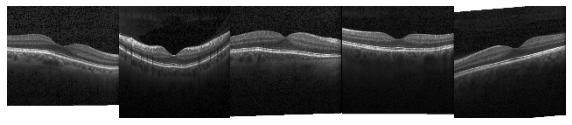

In [11]:
import glob

normalImages = glob.glob('/content/OCT2017/train/NORMAL/**')
cnvImages = glob.glob('/content/OCT2017/train/CNV/**')
dmeImages = glob.glob('/content/train/NORMAL/**')
drusenImages = glob.glob('/content/OCT2017/train/DRUSEN/**')

print("Normal")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in normalImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

CNV


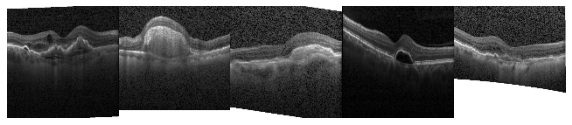

In [12]:
print("CNV")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in cnvImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

In [13]:
print("DME")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in dmeImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

DME


<Figure size 720x720 with 0 Axes>

DRUSEN


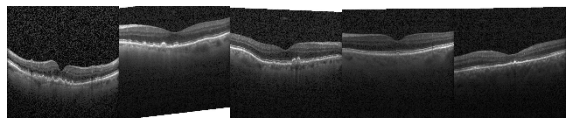

In [14]:
print("DRUSEN")
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in drusenImages[:5]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(1, 5, i_+1) #.set_title(l)
    plt.imshow(im); plt.axis('off')
    i_ += 1

# Data Preprocessing

In [16]:
#ImageDataGenerator

datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator = datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
        
val_generator = datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')
        
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False)

Found 83484 images belonging to 4 classes.
Found 32 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


# Model Architecture

Instantiating the pre-trained model.

In [17]:
pretrained_model= tf.keras.applications.Xception(
    include_top=False,
    input_shape=(224,224,3),
    weights='imagenet'
    )

pretrained_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                   

Ensuring that pre-trained model will not learn the weights again.

In [18]:
pretrained_model.trainable = False

Base model.

In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))

scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = pretrained_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x - tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                             

In [20]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

Train Model on OCT data set.

In [21]:
history = model.fit(train_generator, 
                           validation_data=test_generator, 
                           epochs=100,
                           steps_per_epoch=(83484/32),
                           validation_steps=(968/32)
                           )

Epoch 1/100
2608/2608 [==============================] - 411s 153ms/step - loss: 0.4643 - accuracy: 0.8316 - val_loss: 0.3285 - val_accuracy: 0.8564
Epoch 2/100
2608/2608 [==============================] - 341s 131ms/step - loss: 0.3842 - accuracy: 0.8597 - val_loss: 0.2437 - val_accuracy: 0.9050
Epoch 3/100
2608/2608 [==============================] - 335s 129ms/step - loss: 0.3478 - accuracy: 0.8735 - val_loss: 0.2550 - val_accuracy: 0.8957
Epoch 4/100
2608/2608 [==============================] - 334s 128ms/step - loss: 0.3210 - accuracy: 0.8834 - val_loss: 0.2226 - val_accuracy: 0.9163
Epoch 5/100
2608/2608 [==============================] - 333s 128ms/step - loss: 0.2998 - accuracy: 0.8912 - val_loss: 0.2028 - val_accuracy: 0.9246
Epoch 6/100
2608/2608 [==============================] - 333s 128ms/step - loss: 0.2824 - accuracy: 0.8967 - val_loss: 0.1709 - val_accuracy: 0.9339
Epoch 7/100
2608/2608 [==============================] - 332s 127ms/step - loss: 0.2652 - accuracy: 0.9038

Evaluating Model Performance

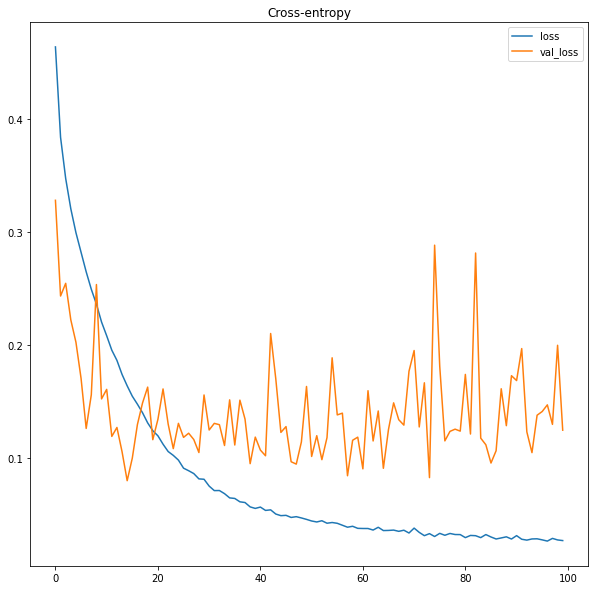

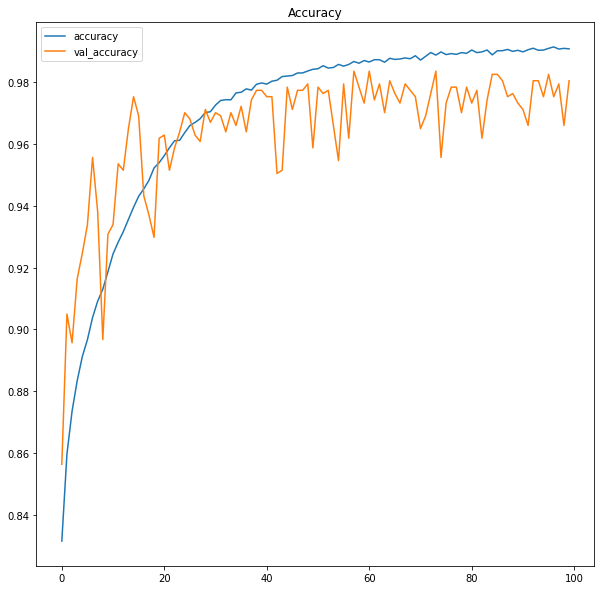

In [22]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [23]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)

predictions = model.predict(test_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

In [24]:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

In [25]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

         CNV       0.96      1.00      0.98       242
         DME       1.00      0.95      0.97       242
      DRUSEN       0.98      0.99      0.99       242
      NORMAL       0.98      0.99      0.98       242

    accuracy                           0.98       968
   macro avg       0.98      0.98      0.98       968
weighted avg       0.98      0.98      0.98       968



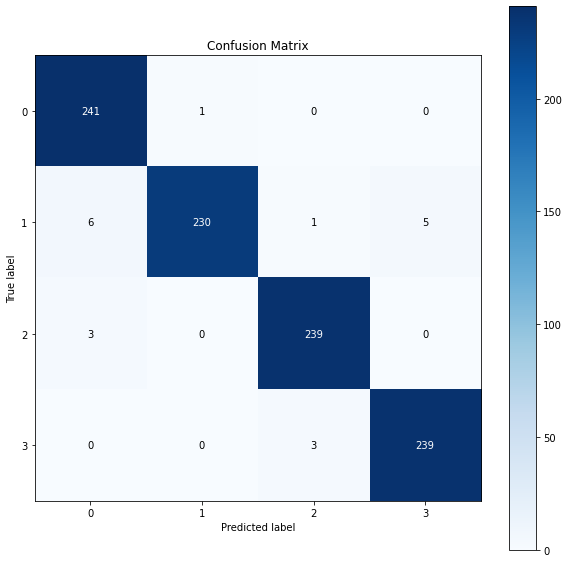

In [27]:
plot_confusion_matrix(true_classes, predicted_classes)

plt.show()

Export Model

In [28]:
OCT_SAVED_MODEL = "oct_saved_model"

model_save_path = '/content/drive/MyDrive/FourthBrain/Capstone_Project/Model_TFLite/'

full_model_save_path = os.path.join(model_save_path, OCT_SAVED_MODEL)

tf.saved_model.save(model, full_model_save_path)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/FourthBrain/Capstone_Project/Model_TFLite/oct_saved_model/assets


Convert with TFLite and save model

In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(full_model_save_path)

tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)